In [ ]:
# import the necessary packages
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import seaborn as sns
import cv2,os
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from scipy.spatial import distance

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


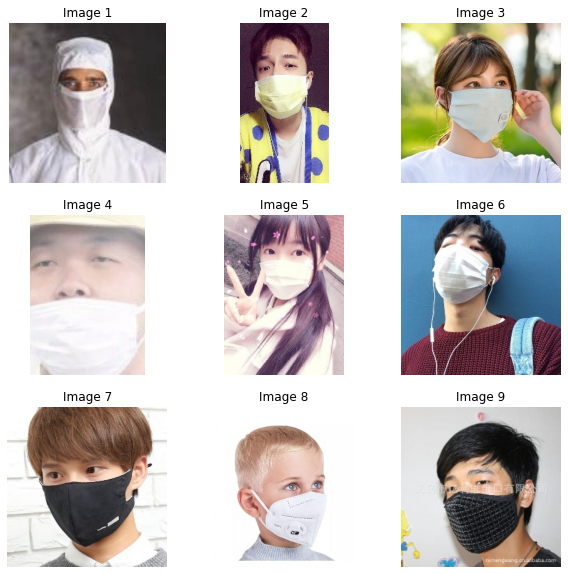

In [ ]:
i = 0
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
for dirname, _, filenames in os.walk(r'/content/drive/MyDrive/dataset/data/with_mask'):
    for filename in filenames[:9]:
        img = cv2.imread(os.path.join(dirname, filename))
        if img is not None:
            img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)
            img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
            ax = list(axes.flatten())[i]
            ax.imshow(img)
            ax.set_title('Image ' + str(i+1))
            ax.axis('off')
            i += 1
plt.show()

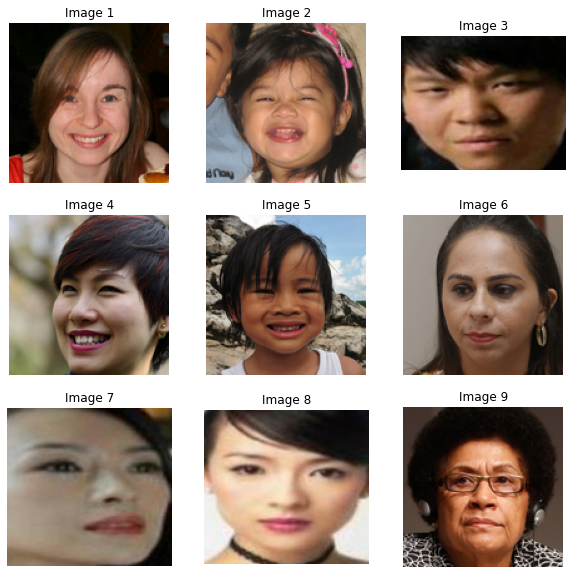

In [ ]:
i = 0
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
for dirname, _, filenames in os.walk(r'/content/drive/MyDrive/dataset/data/without_mask'):
    for filename in filenames[:9]:
        img = cv2.imread(os.path.join(dirname, filename))
        if img is not None:
            img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)
            img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
            ax = list(axes.flatten())[i]
            ax.imshow(img)
            ax.set_title('Image ' + str(i+1))
            ax.axis('off')
            i += 1
plt.show()

## Data preprocessing step

In [ ]:
# The images were stored in a ‘dataset’ directory which had two folders, one titled ‘with mask’ and one titled ‘without mask’. These folder names became our class labels.

import cv2,os

# calling dataset
data_path= r'/content/drive/MyDrive/dataset/data'

# load folder name as categories
categories=os.listdir(data_path)

# array is created to call the number of folders inside the dataset.
labels=[i for i in range(len(categories))]

# a dictonary is created to zip the categories and label.
label_dict=dict(zip(categories,labels)) #empty dictionary

print(label_dict)
print(categories)
print(labels)

{'with_mask': 0, 'without_mask': 1}
['with_mask', 'without_mask']
[0, 1]


In [ ]:
# For each image in both folders, we used the cv2.cvtColor function to convert the BGR image to a Grayscale image. 
# We then used the cv2.resize function to resize our image to dimensions (img_size, img_size). 
# Our img_size parameter was set to 100, and so each image becomes a 100 x 100 square image. 
# The prepared image is appended to the ‘data’ list, and the class label is appended to the ‘target’ list.

# size is set to 100*100 and two empty list to save the images.
img_size=100
data=[]
target=[]

# We will call the two categories in the for loop here and then the image name from the folders.
for category in categories:
    folder_path=os.path.join(data_path,category)
    img_names=os.listdir(folder_path)

# All the images from the image path is calling here
    for img_name in img_names:
        img_path=os.path.join(folder_path,img_name)
        img=cv2.imread(img_path)

        try:
            gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)           
            #Coverting the image into gray scale

            resized=cv2.resize(gray,(img_size,img_size))
            #resizing the gray scale into 100*100, since we need a fixed common size for all the images in the dataset
            
            data.append(resized)
            # add the prepared image into the data array
            
            target.append(label_dict[category])
            #appending the image and the label(categorized) into the list (dataset)

        except Exception as e:
            print('Exception:',e)
            #if any exception rasied, the exception will be printed here. And pass to the next image

In [ ]:
"""To reduce model complexity and optimize training time, we can first convert the ‘data’ list to a more efficient numpy array, 
and then divide the array by 255-this will normalise the pixel range to between 0 and 1. The data will have dimensions 
(no. of images, img_size, img_size, colour channel). The ‘target’ list can also be converted to a numpy array and then converted
to a one-hot encoding vector. np.save saves the arrays to a binary file in numpy format."""

# normalize image by 255 which will convert the pixel range into 0 and 1.
data=np.array(data)/255.0

# data will have a shape of (number of images,h,w,colour channel)
data=np.reshape(data,(data.shape[0],img_size,img_size,1))

# turn the target array as np array
target=np.array(target)

from keras.utils import np_utils

# convert array of labeled data(from 0 to nb_classes - 1) to one-hot vector.
new_target=np_utils.to_categorical(target)

In [ ]:
np.save('data',data) #images
np.save('target',new_target) #target values 0/1

# Training the model

## CNN

In [ ]:
# loading the data and target numpy arrays.

data=np.load('data.npy')
target=np.load('target.npy')

In [ ]:
data.shape

(10000, 100, 100, 1)

In [ ]:
data.shape[1:]

(100, 100, 1)

In [ ]:
target.shape

(10000, 2)

In [ ]:
# CNN architecture — 2 Conv layers, 2 Max Pooling, 2 FC (including output layer)

from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten,Dropout
from keras.layers import Conv2D,MaxPooling2D
from keras.callbacks import ModelCheckpoint

# Initialize the model
model=Sequential()

#The first CNN layer followed by Relu and MaxPooling layers
model.add(Conv2D(200,(3,3),input_shape=data.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

#The second convolution layer followed by Relu and MaxPooling layers
model.add(Conv2D(100,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

# Flatten layer to stack the output convolutions from second convolution layer
model.add(Flatten())
# Dropout to prevent model overfitting to data
model.add(Dropout(0.5))
#Dense layer of 50 neurons
model.add(Dense(50,activation='relu'))
# The Final layer with two outputs for two categories
# Softmax to give us the probability that the image is in either category
model.add(Dense(2,activation='softmax'))

model.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])

In [ ]:
# Split the test and train data for the model.
# train_data and test_data will be the x train and x test
# train_target and test_target will be the y train and y test
# 20% of the data will be used for testing and 80% of the data will be used for training.

from sklearn.model_selection import train_test_split

train_data,test_data,train_target,test_target=train_test_split(data,target,test_size=0.2)

In [ ]:
# A checkpoint is created to monitor to the validation loss and save the best performing model.
# train the model using model.fit and 20% of data is used for validation

checkpoint = ModelCheckpoint('model-{epoch:03d}.model',monitor='val_loss',verbose=0,save_best_only=True,mode='auto')
history=model.fit(train_data,train_target,epochs= 10,callbacks=[checkpoint],validation_split=0.2)

Epoch 1/10
200/200 [==============================] - 477s 2s/step - loss: 0.4896 - accuracy: 0.7798 - val_loss: 0.2349 - val_accuracy: 0.9069
Epoch 2/10
200/200 [==============================] - 468s 2s/step - loss: 0.2512 - accuracy: 0.9067 - val_loss: 0.2170 - val_accuracy: 0.9181
Epoch 3/10
200/200 [==============================] - 472s 2s/step - loss: 0.1685 - accuracy: 0.9358 - val_loss: 0.1569 - val_accuracy: 0.9556
Epoch 4/10
200/200 [==============================] - 470s 2s/step - loss: 0.1346 - accuracy: 0.9497 - val_loss: 0.4620 - val_accuracy: 0.8438
Epoch 5/10
200/200 [==============================] - 470s 2s/step - loss: 0.1124 - accuracy: 0.9577 - val_loss: 0.1634 - val_accuracy: 0.9513
Epoch 6/10
200/200 [==============================] - 471s 2s/step - loss: 0.1007 - accuracy: 0.9655 - val_loss: 0.1558 - val_accuracy: 0.9550
Epoch 7/10
200/200 [==============================] - 471s 2s/step - loss: 0.0926 - accuracy: 0.9663 - val_loss: 0.3879 - val_accuracy: 0.9112

In [ ]:
model.save('cnn_face_mask.h5')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 200)       2000      
                                                                 
 activation (Activation)     (None, 98, 98, 200)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 49, 49, 200)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 100)       180100    
                                                                 
 activation_1 (Activation)   (None, 47, 47, 100)       0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 23, 23, 100)      0         
 2D)                                                    

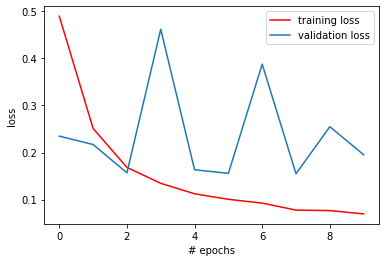

In [ ]:
from matplotlib import pyplot as plt

plt.plot(history.history['loss'],'r',label='training loss')
plt.plot(history.history['val_loss'],label='validation loss')
plt.xlabel('# epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

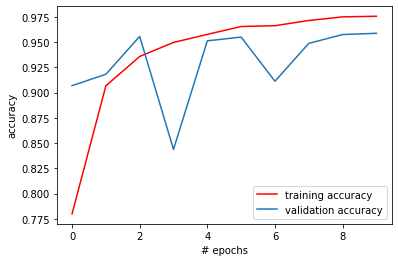

In [ ]:
plt.plot(history.history['accuracy'],'r',label='training accuracy')
plt.plot(history.history['val_accuracy'],label='validation accuracy')
plt.xlabel('# epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [ ]:
# model evaluation of test data

print(model.evaluate(test_data,test_target))

In [ ]:
predictions = (model.predict(test_data) > 0.5).astype("int32")
train_pred= (model.predict(train_data) > 0.5).astype("int32")

In [ ]:
# prediction of test data and train data

from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
print ("Confusion matrix of test data")
print(classification_report(test_target, predictions))

print ("Confusion matrix of train data")
print(classification_report(train_target, train_pred))


# Prediction Using CNN

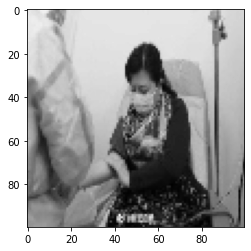

Predicted: 
0
True:
0


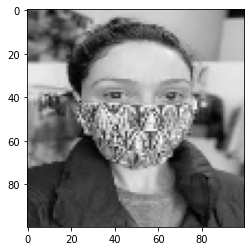

Predicted: 
0
True:
0


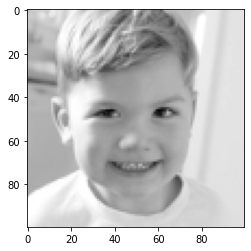

Predicted: 
1
True:
1


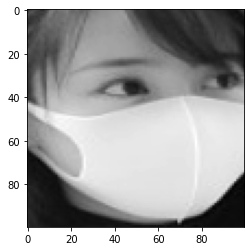

Predicted: 
0
True:
0


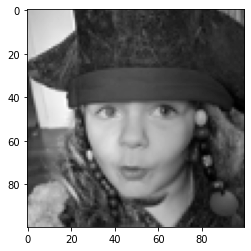

Predicted: 
1
True:
1


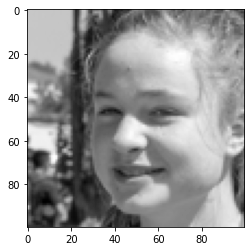

Predicted: 
1
True:
1


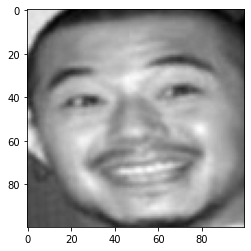

Predicted: 
1
True:
1


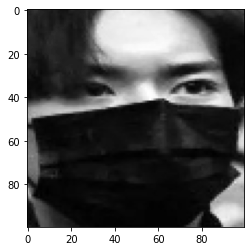

Predicted: 
0
True:
0


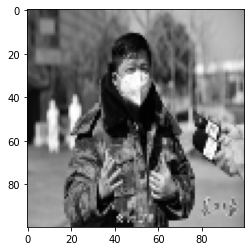

Predicted: 
0
True:
0


In [ ]:
Predictions=model.predict(test_data[1:10])
for i in range(1,10):
    X_1=test_data[i]
    Y_1=test_target[i]
    plt.imshow(X_1[:,:,0], cmap='gray')
    plt.show()
    print("Predicted: ")
    print(np.argmax(Predictions[i-10]))
    print("True:")
    print(np.argmax(test_target[i]))